In [7]:
from MMT_reduce_module import *

In [8]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt

from shift_methods import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (Updated 7/6/2019): 

* Fix saturated data!
    * Examine how sky frames are being made -- **done, 7/5**
    * Examine how sky subtraction is being performed on science data -- **done, 7/5**
    * Determine best practice of aligning saturated frames -- **done, 7/6**
    * plt.imshow reduced steps -- **done, sometime**
    * Stacking size issue -- **done**
    * Update placeholder star position in saturated images from 512, 512 (before measuring companion positions)  
    
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 7/5):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Define location for reduced data to be written -- **done, 7/1**
* Check to ensure all flatfields are taken in the same filter - update within module -- **done, 7/1**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module and here -- **done, 7/5**
* Make sure align flag opens ds9 with frames opening in correct order -- **done, 7/5**
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference

## Cell #1 to Update: Set up paths to raw data and definitions

In [33]:
# Always update and double-check the following seven paths and variables:

path_to_raw_sci = '/Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0/'
path_to_raw_darks = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/darks/'
path_to_raw_flats = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/'

objname = 'HIP12097_30s'

flattype = 0 # 0 for sky, 1 for lamp
saturated = 1 # 0 if unsaturated, 1 if saturated
alignflag = 0 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason

## Cell #2 to Update: Define the x-y position of the saturated star from the first "qim" image

In [34]:
# Update the following with your estimate from ds9
ref_imagex = 215
ref_imagey =  300

# No need to edit these two lines
ref_imagex = 1024 - ref_imagex
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [36]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

scilist.sort()

print(f"Number of science frames found: {len(scilist)} \n")

Number of science frames found: 21 



In [37]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [38]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [39]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0


for ii in range(0, n):
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)

    # flip image left-right, as required for MMT data:
    im = np.fliplr(im)

    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)    





In [40]:
print(angle)
print(im)

[-0.8097801  -0.79223818 -0.78691628 -0.78168544 -0.77638127 -0.72172952
 -0.71567543 -0.70941748 -0.7029843  -0.69229816 -0.6857176  -0.67902415
 -0.67209551 -0.66104097 -0.65400968 -0.64674223 -0.63949708 -0.61916263
 -0.61143682 -0.60370276 -0.59585376]
[[1314.3203  1330.8589  1333.3844  ... 1220.6771  1307.7513     0.     ]
 [1393.9655  1326.654   1336.4957  ... 1421.4031  1451.2681   325.75934]
 [1406.3093  1431.5577  1387.3607  ... 1315.5254  1265.9246   333.6266 ]
 ...
 [2105.857   1677.1624  1567.9668  ... 1524.1453  1442.0865   317.50174]
 [2545.2412  1814.9286  1579.5536  ... 1446.0332  1398.6318   321.8183 ]
 [2637.5386  2113.485   1719.2898  ... 1579.2537  1403.5455   329.59885]]


Creating and applying master darks and flats...

Found 16 darks with exposure times of 30.0. 



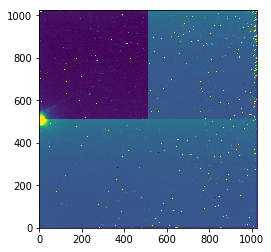

In [41]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_sci, path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [42]:
# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [43]:
flatlist = glob.glob(path_to_raw_flats + '**/q*fits',recursive = True)

Found 51 total flats taken in Ks band filter.

Found 51 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 



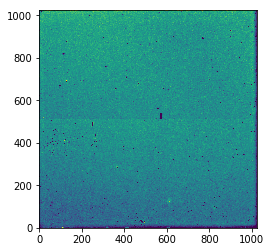

In [44]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_sci, path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [45]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



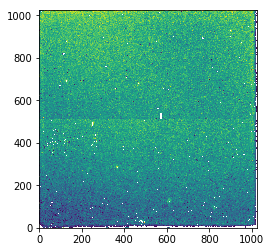

In [46]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(path_to_raw_sci, med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax, origin='lower')

In [47]:
# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20


In [48]:
# write out a test reduced science image 
fits.writeto(path_to_raw_sci+'test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [49]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(path_to_raw_sci, reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



1574.0480876902088


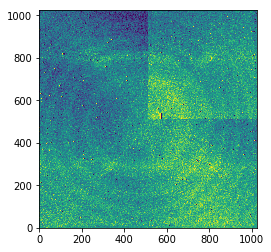

In [50]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [51]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [52]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(path_to_raw_sci+sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Saving reduced frame #20
Time taken:  0.03492383559544881


## Measure Star Centers

In [53]:
# get directory where reduced frames are written
current_dir = path_to_raw_sci

# measure star positions in all of the images
if saturated == 0:
    xcen, ycen = measure_star_centers(path_to_raw_sci, skysub_science_array, scinames_list, sciheader, saturated, alignflag, current_dir, saveframes = True)

elif saturated == 1:    
    xcen, ycen = cross_correlate_centers(path_to_raw_sci, skysub_science_array, scinames_list, ref_imagex, ref_imagey)    

else:
    raiseException("Saturated flag not recognized.")

0.0 0.0
Overwriting existing science frames with star position values: reducedsci_000.fits
9.934443817771239 0.10771418614717732
Overwriting existing science frames with star position values: reducedsci_001.fits
5.370527308678447 -17.9186760622066
Overwriting existing science frames with star position values: reducedsci_002.fits
-13.001685695669039 1.2716545818151417
Overwriting existing science frames with star position values: reducedsci_003.fits
-2.329245498025216 15.695120413075983
Overwriting existing science frames with star position values: reducedsci_004.fits
47.71451643414332 -494.0622267469338
Overwriting existing science frames with star position values: reducedsci_005.fits
24.0 -508.0
Overwriting existing science frames with star position values: reducedsci_006.fits
11.290926367349357 -498.02901779952083
Overwriting existing science frames with star position values: reducedsci_007.fits
31.621783000487994 -476.24594595158464
Overwriting existing science frames with star posi

In [54]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [809.         799.06555618 803.62947269 822.0016857  811.3292455
 761.28548357 785.         797.70907363 777.378217   298.
 306.         329.0193104  302.         322.93555246 333.7974642
 342.77982452 331.11973721 543.93108158 563.89723386 570.33247026
 557.00129438] ycen: [300.         299.89228581 317.91867606 298.72834542 284.30487959
 794.06222675 808.         798.0290178  776.24594595 765.
 782.         764.39566393 752.         272.2055147  296.21112787
 269.18843356 261.26193087 526.20941948 549.1494939  527.39230925
 508.64865624]


In [55]:
#SHIFTED_IMAGES
#STACKED
#FINAL

# get current directory where reduced frames are written
current_dir = path_to_raw_sci

t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(path_to_raw_sci, xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2141 2157
Shifting image 0 of 21...
Shifting image 1 of 21...
Shifting image 2 of 21...
Shifting image 3 of 21...
Shifting image 4 of 21...
Shifting image 5 of 21...
Shifting image 6 of 21...
Shifting image 7 of 21...
Shifting image 8 of 21...
Shifting image 9 of 21...
Shifting image 10 of 21...
Shifting image 11 of 21...
Shifting image 12 of 21...
Shifting image 13 of 21...
Shifting image 14 of 21...
Shifting image 15 of 21...
Shifting image 16 of 21...
Shifting image 17 of 21...
Shifting image 18 of 21...
Shifting image 19 of 21...
Shifting image 20 of 21...
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: MWRFITS.
% Compiled module: FXADDPAR.
% Compiled module: SXDELPAR.
Completed reduction of 21 images in 0.6213286638259887 minutes.









## Run all of the above reduction steps in one go:

In [ ]:
#Running all the above reduction steps in one go
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, ref_imagex, ref_imagey, imsize = 1024)